### Safe deep Q-network

Have a network estimating $Q_w(s, a)$ for $-reward$, $Q^T_w(s, a)$ for stopping time $1$ iff terminal state, $Q^D_w(s, a)$ for constraint (the more the worse). $\pi$ is eps-soft of $Q$
1. Sample action and perform it
2. Sample minibatch from experience replay
3. Perform Bellman update: $\sum\limits_{s, a, r, s'}\left(r+\max_{a'}Q_{w_0}(s', a')-Q_w(s, a)\right)^2$

Networks: $Q_T, Q_D, Q, \pi$

Having collected experience D from the replay buffer:
1. Calculate current policy $\pi_k$ and Q-like functions (TensorFlow)
2. Calculate $\varepsilon$ using policy and $Q$s (TensorFlow)
3. Using policy, Q-functions and $\varepsilon$, solve LP to obtain $\pi'$ (SciPy)
4. Make a step for Bellman update using $\pi,\pi',\varepsilon,Q$ (TensorFlow)
5. Make a step towards minimizing $D_{JSD}(\pi||\pi')$ (TensorFlow)

In [1]:
from xvfbwrapper import Xvfb

#vdisplay = Xvfb()
#vdisplay.start()

# for environ
import os, sys

# only using device 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["LIBGL_ALWAYS_SOFTWARE"]="1"
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

# importing tensorflow
import tensorflow as tf

# import scipy
import scipy, csv

import pandas as pd

# for linprog (faster than scipy...)
import pulp

import datetime

In [2]:
import gym
from gym import wrappers
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

# to display environment data
# see https://gist.github.com/thomelane/79e97630ba46c45985a946cae4805885
from IPython import display

In [3]:
import sys
sys.path += ['/localhome/volodin/local/usr/bin']
sys.path

['',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python36.zip',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/lib-dynload',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/extensions',
 '/localhome/volodin/.ipython',
 '/opt/gurobi201/linux32/lib/python2.5',
 '/opt/gurobi201/linux32/lib/python2.5',
 '/localhome/volodin/local/usr/bin']

In [4]:
from xvfbwrapper import Xvfb

vdisplay = Xvfb()
vdisplay.start()

In [5]:
tf.reset_default_graph()
# allowing GPU memory growth to allocate only what we need
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
sess = tf.Session(config=config, graph = tf.get_default_graph())

In [6]:
env = gym.make('CartPole-v0')

In [7]:
# number of dimensions in state
S_DIM = 4

# number of available actions
ACTIONS = 2

# discount factor
gamma_discount = 0.9

# epsilon-greedy
eps = 0.1

# for softmax
temperature = 1

In [8]:
# states: double the length of actions: from-to-from-to...
states = tf.placeholder(tf.float64, shape = (None, S_DIM,))

# taken actions
actions = tf.placeholder(tf.int64, shape = (None,))

# rewards obtained
rewards = tf.placeholder(tf.float64, shape = (None,))

# costs obtained
costs = tf.placeholder(tf.float64, shape = (None, ))

# is step terminal?
termination = tf.placeholder(tf.float64, shape = (None, ))

# need next q-value (non-terminal state?)
need_next_q = tf.placeholder(tf.float64, shape = (None, ))

# new policy pi'
logits_new_policy = tf.placeholder(tf.float64, shape = (None, ACTIONS))

def fc_layer(x, n, activation = tf.nn.relu):
    """ Fully connected layer for input x and output dim n """
    return tf.contrib.layers.fully_connected(x, n, activation_fn=activation,
    weights_initializer=tf.initializers.lecun_normal(), weights_regularizer=None,
    biases_initializer=tf.zeros_initializer(), biases_regularizer=None, trainable=True)

In [9]:
class ExperienceReplay():
    def __init__(self, N = 1000):
        """ Create experience buffer with capacity N """
        self.N = N
        self.buf = []
    def store(self, exp):
        """ Store one experience """
        self.buf.append(exp)
        
        # removing extra elements
        extra = len(self.buf) - self.N
        if extra > 0:
            self.buf = self.buf[extra:]
            
    def sample(self, how_many = 10):
        """ Sample a mini-batch from the buffer """
        assert len(self.buf) > 0, "Experience buffer is empty, cannot sample"
        indices = np.random.choice(len(self.buf), how_many)
        result = [self.buf[i] for i in indices]
        return result

In [10]:
common_layer = states#fc_layer(states, 20)

In [68]:
def q_like_function(z = common_layer):
    # Q network head
    with tf.name_scope('q_layers'):
        
        # state is an input to the network
        #z = states

        # some fully connected stuff
        z = fc_layer(z, 20)

        # some fully connected stuff
        #z = fc_layer(z, 10)
        
        #z = fc_layer(z, 10)
        #z_policy = fc_layer(z, 10)
        z_policy = z
        z_policy = fc_layer(z_policy, ACTIONS, activation = None)
        q_values = z_policy
        #logits_policy = tf.nn.softmax(z_policy)
        # predicted labels
        logits_policy = tf.nn.softmax(temperature * q_values)
    return q_values, logits_policy

In [12]:
# maximal constraint violation
d0 = tf.placeholder(tf.float64)

In [13]:
q_reward, _ = q_like_function()
q_termination, _ = q_like_function()
q_cost, _ = q_like_function()

In [69]:
_, logits_policy = q_like_function()
# taken logits (from state)
logits_from = logits_policy[0::2]
def dot_and_sum1(Z1, Z2):
    """ Return a vector of length Z1.shape[0] == Z2.shape[0] with i'th entry being sum of Z1ik*Z2ik """
    return tf.reduce_sum(tf.multiply(Z1, Z2), axis = 1)
eps_lyapunov = d0 - dot_and_sum1(logits_policy, q_cost) / dot_and_sum1(logits_policy, q_termination)
q_lyapunov = q_cost + tf.multiply(q_termination, tf.expand_dims(eps_lyapunov, 1))

In [70]:
def mse(x, y):
    """ Mean squared error tensor """
    return tf.reduce_mean(tf.square(tf.cast(x, tf.float64) - tf.cast(y, tf.float64)))

In [71]:
# one-hot encoded actions
a_one_hot = tf.one_hot(actions, ACTIONS)

In [72]:
def soft_bellman_loss(a_one_hot, rewards, q_values_from_to, logits_policy, need_next_q):
    """ Bellman residual w.r.t. actions, rewards and q-values """
    # q-values from-to, equal length
    q_values_from = q_values_from_to[0::2, :]
    q_values_to = q_values_from_to[1::2, :]

    # taken Q value (from)
    q_taken = tf.boolean_mask(q_values_from, a_one_hot)

    # maximal Q value
    # TODO: replace with soft (use logits!)
    #q_max   = tf.reduce_max(tf.stop_gradient(q_values_to), axis = 1)
    q_soft = dot_and_sum1(q_values_to, logits_policy)
    
    # loss tensor (only optimizing over q_taken!)
    loss = mse(rewards + gamma_discount * tf.multiply(need_next_q, tf.stop_gradient(q_soft)), q_taken)
    return loss

In [73]:
def cost(obs):
    """ Calculate scalar cost of one observation """
    assert isinstance(obs, np.ndarray) and obs.shape == (4,), "Input must be an np-array [x xdot phi phidot]"
    
    # parsing input
    x, x_dot, phi, phi_dot = obs
    
    #X_MAX = 1.0
    #X_DOT_MAX = 0.5
    #PHI_MAX = 0.1
    #PHI_DOT_MAX = 0.5
    
    if x < 0 or phi < 0:
        return 1
    
    #if np.any(np.abs([x, x_dot, phi, phi_dot]) > [X_MAX, X_DOT_MAX, PHI_MAX, PHI_DOT_MAX]):
    #    return 1
    
    # in all other cases no cost
    return 0

In [74]:
# Bellmann losses
#loss_r = soft_bellman_loss(a_one_hot, rewards, q_reward, logits_new_policy, need_next_q)
loss_r = soft_bellman_loss(a_one_hot, rewards, q_reward, logits_new_policy, need_next_q)
#loss_r = soft_bellman_loss(a_one_hot, rewards, q_reward, logits_from, need_next_q)
#loss_r = soft_bellman_loss(a_one_hot, rewards, q_reward, logits_reward[0::2], need_next_q)
loss_d = soft_bellman_loss(a_one_hot, costs, q_cost, logits_from, need_next_q)
loss_t = soft_bellman_loss(a_one_hot, termination, q_termination, logits_from, need_next_q)

In [75]:
loss_bellman = loss_r + loss_d + loss_t

In [76]:
# Jensen-Shannon Divergence
# D_{JS}(P, Q) = 0.5 * D_KL(P || M) + 0.5 * D_KL(Q || M)
# M = 0.5 * (P + Q) -> normalized!
def kl(x, y):
    """ KL-divergence """
    X = tf.distributions.Categorical(probs=x)
    Y = tf.distributions.Categorical(probs=y)
    return tf.distributions.kl_divergence(X, Y)
def jsd(x, y):
    M = 0.5 * (x + y)
    return 0.5 * kl(x, M) + 0.5 * kl(y, M)

In [77]:
# logits of policy (taken, from original state)
# using MSE instead of JSD...
loss_jsd = tf.reduce_mean(mse(logits_from, logits_new_policy))

#loss_jsd = tf.reduce_mean(jsd(logits_from, logits_new_policy))

In [78]:
tf.summary.scalar('q_norm_r', tf.reduce_mean(tf.norm(q_reward, axis = 1)))
tf.summary.scalar('q_norm_d', tf.reduce_mean(tf.norm(q_cost, axis = 1)))
tf.summary.scalar('q_norm_t', tf.reduce_mean(tf.norm(q_termination, axis = 1)))
tf.summary.scalar('loss_r', loss_r)
tf.summary.scalar('loss_d', loss_d)
tf.summary.scalar('loss_t', loss_t)
tf.summary.scalar('loss_jsd', loss_jsd)
tf.summary.scalar('mean_act', tf.reduce_mean(tf.cast(tf.argmax(a_one_hot, axis = 1), dtype=tf.float64)))
tf.summary.scalar('episode_length', tf.reduce_sum(tf.shape(rewards)))
tf.summary.scalar('reward', tf.reduce_sum(rewards))
tf.summary.scalar('termination', tf.reduce_sum(termination))
tf.summary.scalar('cost', tf.reduce_sum(costs))
tf.summary.scalar('pi_vs_qR', mse(tf.argmax(q_reward[0::2], axis = 1), tf.argmax(logits_from, axis = 1)))
pass

In [79]:
summary = tf.summary.merge_all()
summary_i = 0
s_writer = tf.summary.FileWriter('./tensorboard/' + str(datetime.datetime.now()))

In [80]:
params = tf.trainable_variables()

In [81]:
def replay_test():
    replay = ExperienceReplay()
    replay.store([1,2])
    replay.store([3,4])
    rs = replay.sample()
    assert [1,2] in rs or [3,4] in rs
    
    replay = ExperienceReplay(N = 3)

    replay.store(1)
    replay.store(2)
    replay.store(3)
    replay.store(4)
    replay.store(5)
    replay.store(6)

    assert replay.buf == [4, 5, 6]
replay_test()

In [82]:
# sample from Q function?
sample_q = True

In [83]:
def sample_action(observation, sample_q = sample_q):
    """ Sample an action from the policy """
    
    if np.random.random() <= eps:
        return env.action_space.sample()
    
    if sample_q: # sampling from the Q-function
        p = sess.run(q_reward, feed_dict = {states: [observation]})[0]
        # argmax for q-function
        return np.argmax(p)
    else: # sampling from the policy
        p = sess.run(logits_policy, feed_dict = {states: [observation]})[0]
    
        # choice for real policy
        return np.random.choice(range(2), p = p)

In [84]:
def get_rollout():
    """ Obtain rollout using policy """
    done = False
    observation = env.reset()
    sarsnc = []
    # S: from state
    # A: action
    # R: reward obtained
    # S: new state
    # N: true if need next (non-terminal)
    # C: cost obtained
    while not done:
        act = sample_action(observation)
        observation_, reward, done, info = env.step(act) # take a random action
        curr = (observation, act, reward, observation_, True, cost(observation_))
        sarsnc.append(curr)
        replay.store(curr)
        
        if done:
            # crucial, otherwise Q blows up...
            replay.store((observation_, sample_action(observation_), reward, observation_, False, cost(observation_)))
        
        observation = observation_
    env.close()
    #print(len(replay.buf), len(sars))
    return sarsnc

In [85]:
# using a separate optimizer for each loss (can have different coefficients...)
losses = [loss_r, loss_d, loss_t, loss_jsd]
bellman_losses = [loss_r, loss_d, loss_t]

def loss_to_opt(lst):
    """ List of losses -> group optimize operation """
    return tf.group([tf.train.AdamOptimizer(0.1).minimize(loss) for loss in lst])
    

# iteration for Bellman updates
opt_bellman = loss_to_opt(bellman_losses)
opt_jsd = loss_to_opt([loss_jsd])

In [86]:
def interleave(A, B):
    """ Interleave two lists A, B: a1b1a2b2... """
    # https://stackoverflow.com/questions/7946798/interleave-multiple-lists-of-the-same-length-in-python
    assert len(A) == len(B), "Must have arrays of same length"
    return [val for tup in zip(A, B) for val in tup]
assert interleave([1,2,3],[4,5,6]) == [1, 4, 2, 5, 3, 6]

In [59]:
def train_step(L = 200, d0_ = 50, learn_policy = False, learn_q = False):
    # sampling same size
    S0, A, R, S1, N, C = list(zip(*replay.sample(L)))
    
    # taking some data from the environment (sampling...)
    #S0, A, R, S1, N, C = zip(*get_rollout())

    # converting to float
    N = 1. * np.array(N)

    # feed dictionary for TF
    feed = {states: interleave(S0, S1), actions: A, rewards: R, costs: C,
            d0: d0_, need_next_q: N, termination: 1 - N}
    
    # obtaining current policy
    pi_k, q_L, q_R, eps_L = sess.run((logits_from, q_lyapunov, q_reward, eps_lyapunov), feed_dict = feed)
    
    # taking FROM for q_L, q_R, eps_L
    q_L = q_L[0::2,:]
    q_R = q_R[0::2,:]
    eps_L = eps_L[0::2]
    
    # sanity check for length
    assert len(q_L) == len(q_R) == len(eps_L) == L

    # if item is 0, replace it to this
    # to fix KL divergence blowing up
    kl_eps = 1e-2
    
    # lower/upper bound for variables
    lb, ub = kl_eps, 1.0
    
    # number of variables: |A| * |Batch|
    n_vars = (pi_k.shape[0] * ACTIONS)
    
    # new policy is initialy None
    pi_new = None
    
    # solving the LP
    # Use https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html
    # to solve a linear program
    try:
        # creating a maximization problem
        prob = pulp.LpProblem("policy", pulp.LpMaximize)
        
        # creating variables lb <= x_i <= ub
        x = pulp.LpVariable.dicts('x', range(n_vars), lowBound=lb, upBound = ub)
        
        # flattening q_R S1A1 S1A2 S2A1 S2A2 ...
        q_Rf = q_R.flatten()
        
        # all variables flattened
        x_vars = [x[i] for i in range(n_vars)]
        
        # adding objective: (Q_R, x)
        prob += pulp.lpSum([Ri * xi for Ri, xi in zip(q_Rf, x_vars)]), "objective"
        
        # sanity check for length
        assert len(q_Rf) == len(x_vars)
        
        # adding constraints
        for i in range(n_vars // ACTIONS):
            # adding probability constraint
            prob += pulp.lpSum([x[2 * i], x[2 * i + 1]]) == 1.0
            
            # NOT including safety...
            continue
            
            cqL = q_L[i, 0]
            cqR = q_L[i, 1]
            xL = x[2 * i]
            xR = x[2 * i + 1]
            prob += pulp.lpSum(xL * cqL + xR * cqR) <= eps_L[i] + pi_k[i,0] * cqL + pi_k[i,1] * cqR

        # solving the problem
        status = prob.solve()
        
        # obtaining new policy
        pi_new = np.array([xx.value() for xx in x_vars])
        #print(pulp.LpStatus[status])
    except:
        pass
        # otherwise, it's N
        #pi_new = float('nan')
        
    # if no new policy, assign it to old policy
    #print(q_R)
    if pi_new is None or np.isnan(np.linalg.norm(pi_new)):
        print('Optimization for pi failed... Only doing Bellman update', sys.exc_info())
        pi_new = pi_k
    else:
        
        
        #print('iszero', pi_new, pi_new == 0.0)

        # fixing kl_eps
        #pi_new[pi_new == 0.0] = kl_eps

        # next policy (zipping back)
        pi_new = np.array([pi_new[0::2], pi_new[1::2]]).T
    
    # argmax(q) = argmax(pi_new)
    assert np.allclose(np.argmax(q_R, axis = 1), np.argmax(pi_new, axis = 1))

    # adding data to FEED dict
    feed[logits_new_policy] = pi_new
    
    if learn_q:
        # running BELLMAN update
        summary_res, _ = sess.run([summary, opt_bellman], feed_dict = feed)
        global summary_i, s_writer
        s_writer.add_summary(summary_res, summary_i)
        summary_i += 1
    
    #print(pi_k, pi_new)
    print("pi_k avg, pi_new avg", np.mean(np.argmax(pi_k, axis = 1)), np.mean(np.argmax(pi_new, axis = 1)), np.min(pi_k), np.max(pi_k))
    
    # only learn policy if said to do so
    if learn_policy:
        # training 10 times for JSD
        for i in range(1):
            summary_res, _ = sess.run([summary, opt_jsd], feed_dict = feed)
            s_writer.add_summary(summary_res, summary_i)
            summary_i += 1
    
    if False:
        print('pi_k', pi_k)
        print('q_L', q_L)
        print('q_R', q_R)
        print('eps_L', eps_L)
        print('pi_new', pi_new)
        print('l_j', l_j)
    
    return np.sum(R), np.sum(C)

In [33]:
def get_current_eps(eps_decay, iteration):
    # finding minimal key s.t. <= iteration
    for key in sorted(eps_decay.keys(), reverse = True):
        if key <= iteration:
            return eps_decay[key]
    print("Error: could not find eps")
    return None

def test_decay():
    eps_decay = {0: 0.9, 100: 0.5, 200: 0.3, 300: 0.1, 500: 0}
    assert get_current_eps(eps_decay, 499) == 0.1
    assert get_current_eps(eps_decay, 1000) == 0
    assert get_current_eps(eps_decay, 500) == 0
    assert get_current_eps(eps_decay, 100) == 0.5
    assert get_current_eps(eps_decay, 0) == 0.9
test_decay()

In [91]:
eps_decay = {0: 0.9, 300: 0.5, 300: 0.1, 400: 0}
#eps_decay = {0: 0.9, 300: 0., 1300: 0.1, 1500: 0}

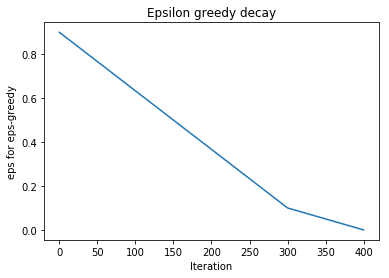

In [92]:
plt.title('Epsilon greedy decay')
plt.ylabel('eps for eps-greedy')
plt.xlabel('Iteration')
plt.plot(eps_decay.keys(), eps_decay.values())
plt.show()

In [93]:
init = tf.global_variables_initializer()
sess.run(init)
replay = ExperienceReplay(N = 5000)
r = []
c = []

In [94]:
eps

0

In [ ]:
# why reward is more than it seems?..

In [101]:
len(get_rollout())

200

In [96]:
# Learning q-network
for i in tqdm(range(500)):
    # obtaining current epsilon for exploration
    #print('GetEps')
    eps = get_current_eps(eps_decay, i)
    
    #print('Rollouts')
    
    # obtaining rollout
    for i in range(2):
        sarsnc = get_rollout()
        _, _, R, _, _, C = zip(*sarsnc)
        r.append(np.sum(R))
        c.append(np.sum(C))
        
    # training the agent
    train_step(L = 100, d0_ = 1000, learn_policy = False, learn_q = True)
    #print(len(replay.buf))

  1%|          | 4/500 [00:00<01:09,  7.17it/s]

pi_k avg, pi_new avg 0.37 0.13 0.37002029478907317 0.6299797052109268
pi_k avg, pi_new avg 0.41 0.08 0.394953062229472 0.605046937770528
pi_k avg, pi_new avg 0.35 0.24 0.3823465815898467 0.6176534184101533
pi_k avg, pi_new avg 0.3 0.05 0.41875501570220497 0.5812449842977951
pi_k avg, pi_new avg 0.32 0.0 0.37002029478907317 0.6299797052109268


  2%|▏         | 10/500 [00:00<00:43, 11.27it/s]

pi_k avg, pi_new avg 0.38 0.43 0.394953062229472 0.605046937770528
pi_k avg, pi_new avg 0.38 0.99 0.37002029478907317 0.6299797052109268
pi_k avg, pi_new avg 0.44 1.0 0.394953062229472 0.605046937770528
pi_k avg, pi_new avg 0.38 1.0 0.4126626620369255 0.5873373379630745
pi_k avg, pi_new avg 0.5 0.64 0.3823465815898467 0.6176534184101533
pi_k avg, pi_new avg 0.39 0.59 0.41449587598396054 0.5855041240160394


  3%|▎         | 16/500 [00:00<00:30, 15.66it/s]

pi_k avg, pi_new avg 0.33 0.66 0.3823465815898467 0.6176534184101533
pi_k avg, pi_new avg 0.32 0.73 0.37002029478907317 0.6299797052109268
pi_k avg, pi_new avg 0.34 0.84 0.41539036538250174 0.5846096346174984
pi_k avg, pi_new avg 0.4 0.92 0.4258736087074611 0.574126391292539
pi_k avg, pi_new avg 0.4 1.0 0.4138411526871305 0.5861588473128695
pi_k avg, pi_new avg 0.31 1.0 0.41875501570220497 0.5812449842977951


  4%|▍         | 22/500 [00:01<00:24, 19.26it/s]

pi_k avg, pi_new avg 0.35 1.0 0.37002029478907317 0.6299797052109268
pi_k avg, pi_new avg 0.34 1.0 0.37002029478907317 0.6299797052109268
pi_k avg, pi_new avg 0.41 1.0 0.394953062229472 0.605046937770528
pi_k avg, pi_new avg 0.39 1.0 0.4221218877024779 0.5778781122975221
pi_k avg, pi_new avg 0.38 1.0 0.4134755505912395 0.5865244494087605


  6%|▌         | 28/500 [00:01<00:21, 21.76it/s]

pi_k avg, pi_new avg 0.43 1.0 0.415300566948886 0.5846994330511139
pi_k avg, pi_new avg 0.43 1.0 0.4130691969341307 0.5869308030658694
pi_k avg, pi_new avg 0.5 1.0 0.41539036538250174 0.5846096346174984
pi_k avg, pi_new avg 0.42 1.0 0.41348037219623207 0.586519627803768
pi_k avg, pi_new avg 0.4 1.0 0.42081914843545243 0.5791808515645476
pi_k avg, pi_new avg 0.34 1.0 0.415300566948886 0.5846994330511139


  6%|▌         | 31/500 [00:01<00:20, 22.46it/s]

pi_k avg, pi_new avg 0.37 1.0 0.4201130671619942 0.5798869328380057
pi_k avg, pi_new avg 0.35 1.0 0.4130691969341307 0.5869308030658694
pi_k avg, pi_new avg 0.36 1.0 0.42138496241015055 0.5786150375898494
pi_k avg, pi_new avg 0.39 0.99 0.4259755869924423 0.5740244130075577
pi_k avg, pi_new avg 0.33 0.88 0.41449587598396054 0.5855041240160394


  7%|▋         | 37/500 [00:01<00:19, 23.40it/s]

pi_k avg, pi_new avg 0.28 0.0 0.41945079333472085 0.5805492066652791
pi_k avg, pi_new avg 0.36 0.0 0.4174107076375905 0.5825892923624095
pi_k avg, pi_new avg 0.32 0.0 0.4129035460012357 0.5870964539987643
pi_k avg, pi_new avg 0.35 0.0 0.3823465815898467 0.6176534184101533
pi_k avg, pi_new avg 0.47 0.0 0.4291109834956792 0.5708890165043208
pi_k avg, pi_new avg 0.43 0.0 0.41517387338287487 0.5848261266171252


  9%|▊         | 43/500 [00:01<00:18, 24.18it/s]

pi_k avg, pi_new avg 0.37 0.0 0.4041003398269708 0.5958996601730291
pi_k avg, pi_new avg 0.34 0.0 0.42472310876562236 0.5752768912343776
pi_k avg, pi_new avg 0.42 0.0 0.42222512351544494 0.5777748764845551
pi_k avg, pi_new avg 0.49 0.0 0.3823465815898467 0.6176534184101533
pi_k avg, pi_new avg 0.37 0.0 0.415300566948886 0.5846994330511139
pi_k avg, pi_new avg 0.45 0.0 0.4198308402453624 0.5801691597546376


 10%|▉         | 49/500 [00:02<00:18, 24.63it/s]

pi_k avg, pi_new avg 0.37 0.0 0.4129870509424271 0.587012949057573
pi_k avg, pi_new avg 0.37 0.0 0.4067515585432505 0.5932484414567495
pi_k avg, pi_new avg 0.46 0.0 0.4031949915748321 0.596805008425168
pi_k avg, pi_new avg 0.46 0.0 0.4129035460012357 0.5870964539987643
pi_k avg, pi_new avg 0.55 0.0 0.4129870509424271 0.587012949057573
pi_k avg, pi_new avg 0.35 0.0 0.41348037219623207 0.586519627803768


 11%|█         | 55/500 [00:02<00:17, 24.73it/s]

pi_k avg, pi_new avg 0.43 0.0 0.415300566948886 0.5846994330511139
pi_k avg, pi_new avg 0.45 0.0 0.41449587598396054 0.5855041240160394
pi_k avg, pi_new avg 0.5 0.0 0.41539036538250174 0.5846096346174984
pi_k avg, pi_new avg 0.46 0.0 0.41659480455639647 0.5834051954436036
pi_k avg, pi_new avg 0.44 0.0 0.4169964439613383 0.5830035560386618


 12%|█▏        | 61/500 [00:02<00:17, 24.71it/s]

pi_k avg, pi_new avg 0.44 0.0 0.4200942115254528 0.5799057884745472
pi_k avg, pi_new avg 0.42 0.0 0.3823465815898467 0.6176534184101533
pi_k avg, pi_new avg 0.4 0.0 0.4077938418351665 0.5922061581648335
pi_k avg, pi_new avg 0.45 0.0 0.4067515585432505 0.5932484414567495
pi_k avg, pi_new avg 0.52 0.0 0.4095735124230458 0.5904264875769542


 13%|█▎        | 64/500 [00:02<00:17, 24.80it/s]

pi_k avg, pi_new avg 0.47 0.0 0.4154553520316416 0.5845446479683585
pi_k avg, pi_new avg 0.46 0.0 0.39139858509685554 0.6086014149031443
pi_k avg, pi_new avg 0.45 0.0 0.40444225060778216 0.5955577493922178
pi_k avg, pi_new avg 0.54 0.0 0.38563738698854105 0.6143626130114589
pi_k avg, pi_new avg 0.44 0.0 0.36600916572080366 0.6339908342791962


 14%|█▍        | 70/500 [00:02<00:17, 24.82it/s]

pi_k avg, pi_new avg 0.49 0.0 0.3824656669788115 0.6175343330211885
pi_k avg, pi_new avg 0.54 0.0 0.3785495494469673 0.6214504505530327
pi_k avg, pi_new avg 0.48 0.0 0.42511996104980043 0.5748800389501995
pi_k avg, pi_new avg 0.45 0.0 0.4129870509424271 0.587012949057573
pi_k avg, pi_new avg 0.37 0.0 0.37002029478907317 0.6299797052109268
pi_k avg, pi_new avg 0.42 0.12 0.37840350531703726 0.6215964946829627


 15%|█▌        | 76/500 [00:03<00:17, 24.89it/s]

pi_k avg, pi_new avg 0.53 0.43 0.37002029478907317 0.6299797052109268
pi_k avg, pi_new avg 0.4 0.38 0.4077938418351665 0.5922061581648335
pi_k avg, pi_new avg 0.45 0.51 0.394953062229472 0.605046937770528
pi_k avg, pi_new avg 0.47 0.5 0.41765330011745877 0.5823466998825413
pi_k avg, pi_new avg 0.41 0.48 0.4041798192703259 0.5958201807296741


 16%|█▋        | 82/500 [00:03<00:16, 24.73it/s]

pi_k avg, pi_new avg 0.52 0.54 0.37002029478907317 0.6299797052109268
pi_k avg, pi_new avg 0.48 0.44 0.4136335803330754 0.5863664196669246
pi_k avg, pi_new avg 0.46 0.39 0.4116540814408448 0.5883459185591552
pi_k avg, pi_new avg 0.46 0.42 0.3677300944932428 0.6322699055067572
pi_k avg, pi_new avg 0.38 0.33 0.41300592207626424 0.5869940779237358


 18%|█▊        | 88/500 [00:03<00:16, 24.78it/s]

pi_k avg, pi_new avg 0.42 0.46 0.42102199094107146 0.5789780090589285
pi_k avg, pi_new avg 0.43 0.53 0.4126626620369255 0.5873373379630745
pi_k avg, pi_new avg 0.51 0.66 0.41158494684960173 0.5884150531503982
pi_k avg, pi_new avg 0.52 0.75 0.4041798192703259 0.5958201807296741
pi_k avg, pi_new avg 0.46 0.77 0.36872086704511003 0.6312791329548899
pi_k avg, pi_new avg 0.49 1.0 0.3732610419807609 0.6267389580192391


 19%|█▉        | 94/500 [00:03<00:16, 24.84it/s]

pi_k avg, pi_new avg 0.44 1.0 0.38563738698854105 0.6143626130114589
pi_k avg, pi_new avg 0.41 1.0 0.41945079333472085 0.5805492066652791
pi_k avg, pi_new avg 0.52 1.0 0.4138420624959109 0.5861579375040891
pi_k avg, pi_new avg 0.47 1.0 0.4126626620369255 0.5873373379630745
pi_k avg, pi_new avg 0.45 1.0 0.4231101246274198 0.5768898753725801
pi_k avg, pi_new avg 0.42 1.0 0.36872086704511003 0.6312791329548899


 19%|█▉        | 97/500 [00:04<00:16, 24.80it/s]

pi_k avg, pi_new avg 0.47 1.0 0.41669777480646686 0.5833022251935331
pi_k avg, pi_new avg 0.48 1.0 0.4098838094723364 0.5901161905276636
pi_k avg, pi_new avg 0.46 0.98 0.35569358534714257 0.6443064146528574
pi_k avg, pi_new avg 0.44 0.98 0.41517387338287487 0.5848261266171252
pi_k avg, pi_new avg 0.47 0.93 0.41448410833691407 0.5855158916630858


 21%|██        | 103/500 [00:04<00:16, 24.73it/s]

pi_k avg, pi_new avg 0.43 0.91 0.32658570348595106 0.673414296514049
pi_k avg, pi_new avg 0.53 0.91 0.3947928608734164 0.6052071391265835
pi_k avg, pi_new avg 0.38 1.0 0.41669777480646686 0.5833022251935331
pi_k avg, pi_new avg 0.5 0.92 0.36152627791570463 0.6384737220842953
pi_k avg, pi_new avg 0.43 0.97 0.3653283012583942 0.6346716987416058


 22%|██▏       | 109/500 [00:04<00:15, 24.64it/s]

pi_k avg, pi_new avg 0.47 1.0 0.3575121500535963 0.6424878499464037
pi_k avg, pi_new avg 0.41 1.0 0.40189566544929767 0.5981043345507023
pi_k avg, pi_new avg 0.48 1.0 0.3575121500535963 0.6424878499464037
pi_k avg, pi_new avg 0.46 1.0 0.3785495494469673 0.6214504505530327
pi_k avg, pi_new avg 0.51 1.0 0.3799896418646967 0.6200103581353033


 22%|██▏       | 112/500 [00:04<00:15, 24.27it/s]

pi_k avg, pi_new avg 0.43 1.0 0.38563738698854105 0.6143626130114589
pi_k avg, pi_new avg 0.46 1.0 0.4072568613609547 0.5927431386390453
pi_k avg, pi_new avg 0.42 0.86 0.3908302785887054 0.6091697214112947
pi_k avg, pi_new avg 0.47 0.78 0.385315453058391 0.6146845469416091
pi_k avg, pi_new avg 0.45 0.69 0.3455868348838179 0.6544131651161821


 24%|██▎       | 118/500 [00:04<00:15, 24.14it/s]

pi_k avg, pi_new avg 0.56 0.63 0.35013439396398643 0.6498656060360136
pi_k avg, pi_new avg 0.53 0.61 0.3616001716089243 0.6383998283910756
pi_k avg, pi_new avg 0.48 0.63 0.3902873749526471 0.6097126250473529
pi_k avg, pi_new avg 0.37 0.56 0.40226487935721317 0.5977351206427868
pi_k avg, pi_new avg 0.45 0.65 0.35013439396398643 0.6498656060360136


 25%|██▍       | 124/500 [00:05<00:15, 23.78it/s]

pi_k avg, pi_new avg 0.47 0.63 0.37989282530101454 0.6201071746989855
pi_k avg, pi_new avg 0.48 0.66 0.35013439396398643 0.6498656060360136
pi_k avg, pi_new avg 0.45 0.65 0.40316462362294425 0.5968353763770557
pi_k avg, pi_new avg 0.32 0.54 0.3664472549555379 0.6335527450444621
pi_k avg, pi_new avg 0.46 0.56 0.3947928608734164 0.6052071391265835


 25%|██▌       | 127/500 [00:05<00:15, 23.89it/s]

pi_k avg, pi_new avg 0.42 0.52 0.40347058961263815 0.5965294103873618
pi_k avg, pi_new avg 0.38 0.48 0.353796795655445 0.6462032043445551
pi_k avg, pi_new avg 0.37 0.43 0.40347058961263815 0.5965294103873618
pi_k avg, pi_new avg 0.48 0.62 0.3445478085698722 0.6554521914301279
pi_k avg, pi_new avg 0.49 0.6 0.35371879687039903 0.6462812031296009


 27%|██▋       | 133/500 [00:05<00:15, 23.62it/s]

pi_k avg, pi_new avg 0.5 0.56 0.39849348744286944 0.6015065125571305
pi_k avg, pi_new avg 0.5 0.71 0.36114016102922414 0.6388598389707758
pi_k avg, pi_new avg 0.47 0.61 0.3799896418646967 0.6200103581353033
pi_k avg, pi_new avg 0.49 0.67 0.39139858509685554 0.6086014149031443
pi_k avg, pi_new avg 0.42 0.68 0.37989282530101454 0.6201071746989855


 28%|██▊       | 139/500 [00:05<00:15, 23.73it/s]

pi_k avg, pi_new avg 0.46 0.68 0.39552460728877453 0.6044753927112254
pi_k avg, pi_new avg 0.52 0.68 0.2687325524710926 0.7312674475289074
pi_k avg, pi_new avg 0.42 0.6 0.3824656669788115 0.6175343330211885
pi_k avg, pi_new avg 0.46 0.56 0.3181207646342146 0.6818792353657853
pi_k avg, pi_new avg 0.55 0.69 0.353796795655445 0.6462032043445551


 28%|██▊       | 142/500 [00:05<00:15, 23.72it/s]

pi_k avg, pi_new avg 0.51 0.61 0.4031657548962366 0.5968342451037634
pi_k avg, pi_new avg 0.47 0.59 0.3500512145597427 0.6499487854402572
pi_k avg, pi_new avg 0.41 0.39 0.37968279586194886 0.6203172041380511
pi_k avg, pi_new avg 0.44 0.36 0.3484394430005824 0.6515605569994176
pi_k avg, pi_new avg 0.5 0.44 0.40863345772405263 0.5913665422759474


 30%|██▉       | 148/500 [00:06<00:14, 23.78it/s]

pi_k avg, pi_new avg 0.44 0.37 0.36872086704511003 0.6312791329548899
pi_k avg, pi_new avg 0.55 0.47 0.4109655794764469 0.5890344205235531
pi_k avg, pi_new avg 0.47 0.42 0.3664472549555379 0.6335527450444621
pi_k avg, pi_new avg 0.57 0.41 0.3799896418646967 0.6200103581353033
pi_k avg, pi_new avg 0.49 0.46 0.39722223875862545 0.6027777612413746


 31%|███       | 154/500 [00:06<00:14, 23.93it/s]

pi_k avg, pi_new avg 0.51 0.58 0.3500512145597427 0.6499487854402572
pi_k avg, pi_new avg 0.41 0.54 0.3664981312888893 0.6335018687111108
pi_k avg, pi_new avg 0.42 0.52 0.2687325524710926 0.7312674475289074
pi_k avg, pi_new avg 0.4 0.57 0.34903073307149046 0.6509692669285095
pi_k avg, pi_new avg 0.55 0.63 0.3785495494469673 0.6214504505530327


 31%|███▏      | 157/500 [00:06<00:14, 23.88it/s]

pi_k avg, pi_new avg 0.38 0.43 0.3870979999335634 0.6129020000664366
pi_k avg, pi_new avg 0.47 0.41 0.3870979999335634 0.6129020000664366
pi_k avg, pi_new avg 0.44 0.35 0.34903073307149046 0.6509692669285095
pi_k avg, pi_new avg 0.39 0.28 0.40567612180613144 0.5943238781938686
pi_k avg, pi_new avg 0.41 0.2 0.3484394430005824 0.6515605569994176


 33%|███▎      | 163/500 [00:06<00:13, 24.08it/s]

pi_k avg, pi_new avg 0.36 0.11 0.35013439396398643 0.6498656060360136
pi_k avg, pi_new avg 0.43 0.27 0.4195251929555116 0.5804748070444884
pi_k avg, pi_new avg 0.46 0.29 0.40316462362294425 0.5968353763770557
pi_k avg, pi_new avg 0.45 0.35 0.385315453058391 0.6146845469416091
pi_k avg, pi_new avg 0.45 0.3 0.30186630527027297 0.698133694729727


 34%|███▍      | 169/500 [00:07<00:13, 23.80it/s]

pi_k avg, pi_new avg 0.38 0.36 0.3181207646342146 0.6818792353657853
pi_k avg, pi_new avg 0.38 0.39 0.3840242228713381 0.6159757771286618
pi_k avg, pi_new avg 0.4 0.41 0.3363219913636723 0.6636780086363278
pi_k avg, pi_new avg 0.41 0.36 0.41544832323938874 0.5845516767606114
pi_k avg, pi_new avg 0.44 0.43 0.39331321331785446 0.6066867866821456


 34%|███▍      | 172/500 [00:07<00:13, 23.79it/s]

pi_k avg, pi_new avg 0.51 0.49 0.4038682688678984 0.5961317311321016
pi_k avg, pi_new avg 0.39 0.45 0.30186630527027297 0.698133694729727
pi_k avg, pi_new avg 0.38 0.5 0.4107655535220322 0.5892344464779677
pi_k avg, pi_new avg 0.54 0.61 0.41544832323938874 0.5845516767606114
pi_k avg, pi_new avg 0.51 0.67 0.39943574340826266 0.6005642565917374


 36%|███▌      | 178/500 [00:07<00:13, 23.67it/s]

pi_k avg, pi_new avg 0.5 0.57 0.41996148748176465 0.5800385125182353
pi_k avg, pi_new avg 0.46 0.57 0.4078476640980708 0.5921523359019292
pi_k avg, pi_new avg 0.44 0.6 0.40016734336023707 0.5998326566397628
pi_k avg, pi_new avg 0.4 0.52 0.42454551255599954 0.5754544874440004
pi_k avg, pi_new avg 0.41 0.54 0.4182159972732019 0.5817840027267982


 37%|███▋      | 184/500 [00:07<00:13, 23.64it/s]

pi_k avg, pi_new avg 0.39 0.48 0.3664981312888893 0.6335018687111108
pi_k avg, pi_new avg 0.41 0.53 0.38817763784230325 0.6118223621576967
pi_k avg, pi_new avg 0.33 0.35 0.40016734336023707 0.5998326566397628
pi_k avg, pi_new avg 0.46 0.37 0.3833014647203307 0.6166985352796693
pi_k avg, pi_new avg 0.53 0.41 0.3769160897532839 0.6230839102467162


 37%|███▋      | 187/500 [00:07<00:13, 23.63it/s]

pi_k avg, pi_new avg 0.44 0.39 0.3758141972747217 0.6241858027252782
pi_k avg, pi_new avg 0.47 0.34 0.37560943036686456 0.6243905696331354
pi_k avg, pi_new avg 0.4 0.29 0.42159832572796524 0.5784016742720348
pi_k avg, pi_new avg 0.46 0.34 0.3411260907739929 0.658873909226007
pi_k avg, pi_new avg 0.36 0.25 0.2687325524710926 0.7312674475289074


 39%|███▊      | 193/500 [00:08<00:12, 23.96it/s]

pi_k avg, pi_new avg 0.47 0.5 0.30186630527027297 0.698133694729727
pi_k avg, pi_new avg 0.38 0.58 0.4078476640980708 0.5921523359019292
pi_k avg, pi_new avg 0.45 0.57 0.41049769707166295 0.589502302928337
pi_k avg, pi_new avg 0.42 0.51 0.389292257726137 0.6107077422738629
pi_k avg, pi_new avg 0.48 0.55 0.39079450398259996 0.6092054960174


 40%|███▉      | 199/500 [00:08<00:12, 23.65it/s]

pi_k avg, pi_new avg 0.39 0.47 0.38143024298904166 0.6185697570109584
pi_k avg, pi_new avg 0.43 0.51 0.3500512145597427 0.6499487854402572
pi_k avg, pi_new avg 0.48 0.56 0.4089265099568046 0.5910734900431954
pi_k avg, pi_new avg 0.43 0.49 0.42147677856593635 0.5785232214340638
pi_k avg, pi_new avg 0.43 0.5 0.3363219913636723 0.6636780086363278


 40%|████      | 202/500 [00:08<00:12, 23.80it/s]

pi_k avg, pi_new avg 0.52 0.5 0.3181207646342146 0.6818792353657853
pi_k avg, pi_new avg 0.41 0.45 0.42270470801496157 0.5772952919850384
pi_k avg, pi_new avg 0.41 0.35 0.3943050588315453 0.6056949411684548
pi_k avg, pi_new avg 0.48 0.41 0.30186630527027297 0.698133694729727
pi_k avg, pi_new avg 0.38 0.32 0.3848444684279569 0.6151555315720432


 42%|████▏     | 208/500 [00:08<00:12, 23.63it/s]

pi_k avg, pi_new avg 0.51 0.48 0.2687325524710926 0.7312674475289074
pi_k avg, pi_new avg 0.58 0.6 0.38513396091519836 0.6148660390848016
pi_k avg, pi_new avg 0.43 0.54 0.3878076734364171 0.6121923265635829
pi_k avg, pi_new avg 0.49 0.55 0.3482777660907567 0.6517222339092433
pi_k avg, pi_new avg 0.38 0.46 0.4244588530614632 0.5755411469385369


 43%|████▎     | 214/500 [00:08<00:12, 23.59it/s]

pi_k avg, pi_new avg 0.42 0.53 0.4098692546863748 0.5901307453136251
pi_k avg, pi_new avg 0.33 0.42 0.3932047650028072 0.6067952349971928
pi_k avg, pi_new avg 0.42 0.55 0.40974680472368163 0.5902531952763185
pi_k avg, pi_new avg 0.51 0.54 0.40072168348684944 0.5992783165131506
pi_k avg, pi_new avg 0.45 0.59 0.39722223875862545 0.6027777612413746


 43%|████▎     | 217/500 [00:09<00:11, 23.79it/s]

pi_k avg, pi_new avg 0.47 0.59 0.41197989430693427 0.5880201056930657
pi_k avg, pi_new avg 0.46 0.48 0.42476904113021374 0.5752309588697863
pi_k avg, pi_new avg 0.49 0.5 0.38513396091519836 0.6148660390848016
pi_k avg, pi_new avg 0.46 0.47 0.3774607793270122 0.6225392206729877
pi_k avg, pi_new avg 0.43 0.47 0.38513396091519836 0.6148660390848016


 45%|████▍     | 223/500 [00:09<00:11, 23.97it/s]

pi_k avg, pi_new avg 0.5 0.39 0.419379736811559 0.580620263188441
pi_k avg, pi_new avg 0.37 0.31 0.38105061983751437 0.6189493801624857
pi_k avg, pi_new avg 0.41 0.27 0.3181207646342146 0.6818792353657853
pi_k avg, pi_new avg 0.47 0.32 0.389292257726137 0.6107077422738629
pi_k avg, pi_new avg 0.56 0.48 0.39764337027364144 0.6023566297263586


 46%|████▌     | 229/500 [00:09<00:11, 23.75it/s]

pi_k avg, pi_new avg 0.37 0.31 0.40665699293692725 0.5933430070630729
pi_k avg, pi_new avg 0.52 0.52 0.4047529886068543 0.5952470113931457
pi_k avg, pi_new avg 0.43 0.52 0.40974680472368163 0.5902531952763185
pi_k avg, pi_new avg 0.4 0.5 0.4200357165322926 0.5799642834677073
pi_k avg, pi_new avg 0.48 0.59 0.3758141972747217 0.6241858027252782


 46%|████▋     | 232/500 [00:09<00:11, 23.64it/s]

pi_k avg, pi_new avg 0.42 0.45 0.3789743377284739 0.6210256622715262
pi_k avg, pi_new avg 0.55 0.61 0.4001568703445772 0.5998431296554227
pi_k avg, pi_new avg 0.44 0.56 0.4081368372877517 0.5918631627122483
pi_k avg, pi_new avg 0.51 0.56 0.4228003080511655 0.5771996919488345
pi_k avg, pi_new avg 0.5 0.56 0.39244430546116876 0.6075556945388313


 48%|████▊     | 238/500 [00:09<00:11, 23.66it/s]

pi_k avg, pi_new avg 0.4 0.49 0.37318368955099007 0.62681631044901
pi_k avg, pi_new avg 0.47 0.48 0.37236551360817766 0.6276344863918223
pi_k avg, pi_new avg 0.4 0.37 0.37236551360817766 0.6276344863918223
pi_k avg, pi_new avg 0.46 0.31 0.4098692546863748 0.5901307453136251
pi_k avg, pi_new avg 0.49 0.2 0.4149209354822302 0.5850790645177698


 49%|████▉     | 244/500 [00:10<00:11, 21.56it/s]

pi_k avg, pi_new avg 0.45 0.21 0.4161104130740535 0.5838895869259465
pi_k avg, pi_new avg 0.46 0.31 0.389292257726137 0.6107077422738629
pi_k avg, pi_new avg 0.42 0.35 0.4001568703445772 0.5998431296554227
pi_k avg, pi_new avg 0.49 0.52 0.3789743377284739 0.6210256622715262
pi_k avg, pi_new avg 0.49 0.5 0.4154178086105484 0.5845821913894516


 49%|████▉     | 247/500 [00:10<00:11, 22.31it/s]

pi_k avg, pi_new avg 0.46 0.65 0.4045012608066569 0.5954987391933432
pi_k avg, pi_new avg 0.45 0.62 0.3959224849261302 0.6040775150738699
pi_k avg, pi_new avg 0.58 0.7 0.36819707681383557 0.6318029231861645
pi_k avg, pi_new avg 0.54 0.72 0.4109131116274765 0.5890868883725234
pi_k avg, pi_new avg 0.46 0.63 0.3894586991860379 0.6105413008139622


 51%|█████     | 253/500 [00:10<00:10, 22.80it/s]

pi_k avg, pi_new avg 0.46 0.61 0.4203900318634444 0.5796099681365555
pi_k avg, pi_new avg 0.47 0.69 0.41865757729966085 0.5813424227003391
pi_k avg, pi_new avg 0.43 0.58 0.4177499978222541 0.5822500021777459
pi_k avg, pi_new avg 0.53 0.55 0.38817763784230325 0.6118223621576967
pi_k avg, pi_new avg 0.42 0.37 0.35943398620435324 0.6405660137956467


 52%|█████▏    | 259/500 [00:10<00:10, 23.03it/s]

pi_k avg, pi_new avg 0.54 0.48 0.4058378399641805 0.5941621600358195
pi_k avg, pi_new avg 0.43 0.34 0.40586318533481974 0.5941368146651803
pi_k avg, pi_new avg 0.48 0.45 0.41152595802161157 0.5884740419783885
pi_k avg, pi_new avg 0.43 0.42 0.38340023619668345 0.6165997638033165
pi_k avg, pi_new avg 0.41 0.42 0.41703443286686975 0.5829655671331302


 52%|█████▏    | 262/500 [00:11<00:10, 23.61it/s]

pi_k avg, pi_new avg 0.48 0.48 0.3667224317341711 0.633277568265829
pi_k avg, pi_new avg 0.5 0.46 0.3914989771536823 0.6085010228463177
pi_k avg, pi_new avg 0.49 0.54 0.3795589469670953 0.6204410530329046
pi_k avg, pi_new avg 0.43 0.53 0.3935260246656065 0.6064739753343934
pi_k avg, pi_new avg 0.44 0.56 0.41828010062240084 0.5817198993775992


 54%|█████▎    | 268/500 [00:11<00:09, 23.71it/s]

pi_k avg, pi_new avg 0.41 0.53 0.419379736811559 0.580620263188441
pi_k avg, pi_new avg 0.54 0.59 0.40581331179437163 0.5941866882056284
pi_k avg, pi_new avg 0.48 0.49 0.3789743377284739 0.6210256622715262
pi_k avg, pi_new avg 0.53 0.55 0.40617125656856334 0.5938287434314367
pi_k avg, pi_new avg 0.45 0.56 0.40581331179437163 0.5941866882056284


 55%|█████▍    | 274/500 [00:11<00:09, 23.21it/s]

pi_k avg, pi_new avg 0.54 0.62 0.41221125587814783 0.5877887441218522
pi_k avg, pi_new avg 0.39 0.55 0.41988330725360845 0.5801166927463915
pi_k avg, pi_new avg 0.44 0.6 0.3987134532232976 0.6012865467767023
pi_k avg, pi_new avg 0.56 0.63 0.3667224317341711 0.633277568265829
pi_k avg, pi_new avg 0.58 0.58 0.41829043955315864 0.5817095604468414


 55%|█████▌    | 277/500 [00:11<00:09, 23.40it/s]

pi_k avg, pi_new avg 0.53 0.48 0.3774589521169237 0.6225410478830763
pi_k avg, pi_new avg 0.39 0.41 0.37902855517350714 0.6209714448264929
pi_k avg, pi_new avg 0.44 0.4 0.39044127663661404 0.6095587233633859
pi_k avg, pi_new avg 0.52 0.43 0.40812793624346 0.59187206375654
pi_k avg, pi_new avg 0.42 0.42 0.41441952407480387 0.5855804759251961


 57%|█████▋    | 283/500 [00:11<00:09, 23.42it/s]

pi_k avg, pi_new avg 0.52 0.42 0.3996451839214304 0.6003548160785697
pi_k avg, pi_new avg 0.49 0.37 0.3801148374992771 0.6198851625007228
pi_k avg, pi_new avg 0.42 0.26 0.3667224317341711 0.633277568265829
pi_k avg, pi_new avg 0.43 0.18 0.3848525428712206 0.6151474571287795
pi_k avg, pi_new avg 0.48 0.25 0.38438276398290105 0.615617236017099


 58%|█████▊    | 289/500 [00:12<00:09, 23.20it/s]

pi_k avg, pi_new avg 0.44 0.2 0.4240785009426919 0.575921499057308
pi_k avg, pi_new avg 0.48 0.22 0.37628211231663206 0.623717887683368
pi_k avg, pi_new avg 0.43 0.34 0.37215286271854825 0.6278471372814517
pi_k avg, pi_new avg 0.46 0.37 0.3812341285483565 0.6187658714516435
pi_k avg, pi_new avg 0.42 0.43 0.34470236445494096 0.655297635545059


 58%|█████▊    | 292/500 [00:12<00:08, 23.19it/s]

pi_k avg, pi_new avg 0.53 0.51 0.36014256638517345 0.6398574336148266
pi_k avg, pi_new avg 0.5 0.47 0.37902855517350714 0.6209714448264929
pi_k avg, pi_new avg 0.52 0.57 0.37492060373782143 0.6250793962621786
pi_k avg, pi_new avg 0.37 0.4 0.3812341285483565 0.6187658714516435
pi_k avg, pi_new avg 0.49 0.45 0.37704735276460194 0.6229526472353981


 60%|█████▉    | 298/500 [00:12<00:08, 23.54it/s]

pi_k avg, pi_new avg 0.48 0.41 0.3774589521169237 0.6225410478830763
pi_k avg, pi_new avg 0.53 0.46 0.3934787303640097 0.6065212696359902
pi_k avg, pi_new avg 0.49 0.28 0.3789743377284739 0.6210256622715262
pi_k avg, pi_new avg 0.59 0.33 0.4004709573844944 0.5995290426155055
pi_k avg, pi_new avg 0.44 0.26 0.3683535083431233 0.6316464916568768


 60%|██████    | 301/500 [00:12<00:10, 19.81it/s]

pi_k avg, pi_new avg 0.54 0.41 0.38438276398290105 0.615617236017099
pi_k avg, pi_new avg 0.56 0.52 0.4177113194256082 0.5822886805743918


 61%|██████    | 304/500 [00:13<00:11, 16.37it/s]

pi_k avg, pi_new avg 0.56 0.58 0.41365222761984166 0.5863477723801583
pi_k avg, pi_new avg 0.5 0.67 0.41701731414582405 0.5829826858541759
pi_k avg, pi_new avg 0.53 0.73 0.4117457916700989 0.5882542083299012


 61%|██████    | 306/500 [00:13<00:13, 14.92it/s]

pi_k avg, pi_new avg 0.38 0.64 0.38438276398290105 0.615617236017099
pi_k avg, pi_new avg 0.49 0.8 0.39687312206290365 0.6031268779370964
pi_k avg, pi_new avg 0.41 0.66 0.3919263576419822 0.6080736423580179


 62%|██████▏   | 308/500 [00:13<00:13, 14.15it/s]

pi_k avg, pi_new avg 0.47 0.59 0.3275065051910489 0.672493494808951
pi_k avg, pi_new avg 0.38 0.47 0.37902855517350714 0.6209714448264929


 62%|██████▏   | 310/500 [00:13<00:15, 12.24it/s]

pi_k avg, pi_new avg 0.45 0.53 0.38914921366105737 0.6108507863389427
pi_k avg, pi_new avg 0.39 0.34 0.41131962633783065 0.5886803736621694


 62%|██████▏   | 312/500 [00:13<00:17, 10.75it/s]

pi_k avg, pi_new avg 0.44 0.37 0.3614707390181135 0.6385292609818866
pi_k avg, pi_new avg 0.46 0.4 0.35370899667679667 0.6462910033232034


 63%|██████▎   | 314/500 [00:14<00:20,  9.13it/s]

pi_k avg, pi_new avg 0.38 0.34 0.38920168385158416 0.6107983161484158
pi_k avg, pi_new avg 0.44 0.43 0.4170208926552111 0.5829791073447889


 63%|██████▎   | 317/500 [00:14<00:20,  9.01it/s]

pi_k avg, pi_new avg 0.35 0.5 0.37998780282308536 0.6200121971769146
pi_k avg, pi_new avg 0.44 0.5 0.375985015683973 0.624014984316027
pi_k avg, pi_new avg 0.37 0.51 0.4246301683675842 0.5753698316324157


 64%|██████▍   | 320/500 [00:14<00:19,  9.06it/s]

pi_k avg, pi_new avg 0.32 0.58 0.3183506950923797 0.6816493049076202
pi_k avg, pi_new avg 0.32 0.63 0.40563810345325363 0.5943618965467463
pi_k avg, pi_new avg 0.28 0.63 0.27121747964909043 0.7287825203509096


 65%|██████▍   | 324/500 [00:15<00:17,  9.94it/s]

pi_k avg, pi_new avg 0.36 0.64 0.3947946649403386 0.6052053350596615
pi_k avg, pi_new avg 0.29 0.64 0.32894165505902817 0.6710583449409719
pi_k avg, pi_new avg 0.28 0.71 0.2792128201746254 0.7207871798253747


 65%|██████▌   | 326/500 [00:15<00:16, 10.61it/s]

pi_k avg, pi_new avg 0.4 0.83 0.42177192717902773 0.5782280728209723
pi_k avg, pi_new avg 0.32 0.79 0.34173138803682 0.65826861196318
pi_k avg, pi_new avg 0.29 0.81 0.35359096501931236 0.6464090349806876


 66%|██████▌   | 330/500 [00:15<00:14, 11.70it/s]

pi_k avg, pi_new avg 0.35 0.84 0.3793246750182686 0.6206753249817314
pi_k avg, pi_new avg 0.32 0.74 0.32513974776031596 0.674860252239684
pi_k avg, pi_new avg 0.38 0.8 0.2792128201746254 0.7207871798253747


 66%|██████▋   | 332/500 [00:15<00:13, 12.19it/s]

pi_k avg, pi_new avg 0.26 0.8 0.3799890869333751 0.6200109130666249
pi_k avg, pi_new avg 0.26 0.81 0.3694172421468788 0.6305827578531212
pi_k avg, pi_new avg 0.28 0.79 0.3699674548158886 0.6300325451841113


 67%|██████▋   | 336/500 [00:16<00:12, 12.89it/s]

pi_k avg, pi_new avg 0.32 0.78 0.2901252898174732 0.7098747101825268
pi_k avg, pi_new avg 0.28 0.76 0.27121747964909043 0.7287825203509096
pi_k avg, pi_new avg 0.27 0.78 0.32513974776031596 0.674860252239684


 68%|██████▊   | 338/500 [00:16<00:12, 13.21it/s]

pi_k avg, pi_new avg 0.22 0.6 0.304261298243706 0.6957387017562939
pi_k avg, pi_new avg 0.23 0.63 0.3433791928973846 0.6566208071026155
pi_k avg, pi_new avg 0.17 0.47 0.30954378347201006 0.6904562165279899


 68%|██████▊   | 340/500 [00:16<00:13, 12.26it/s]

pi_k avg, pi_new avg 0.25 0.43 0.2901252898174732 0.7098747101825268
pi_k avg, pi_new avg 0.17 0.31 0.34067208675029725 0.6593279132497027


 69%|██████▉   | 344/500 [00:16<00:13, 11.28it/s]

pi_k avg, pi_new avg 0.24 0.3 0.34993056914079357 0.6500694308592064
pi_k avg, pi_new avg 0.18 0.4 0.35247512993799873 0.6475248700620013
pi_k avg, pi_new avg 0.17 0.49 0.39934086673158964 0.6006591332684103


 69%|██████▉   | 346/500 [00:16<00:13, 11.28it/s]

pi_k avg, pi_new avg 0.14 0.67 0.3530157896673547 0.6469842103326452
pi_k avg, pi_new avg 0.26 0.65 0.40159992072759665 0.5984000792724032
pi_k avg, pi_new avg 0.18 0.57 0.3333649612452774 0.6666350387547226


 70%|███████   | 350/500 [00:17<00:11, 12.60it/s]

pi_k avg, pi_new avg 0.12 0.67 0.34741675882867445 0.6525832411713256
pi_k avg, pi_new avg 0.18 0.74 0.4025659970220416 0.5974340029779583
pi_k avg, pi_new avg 0.25 0.71 0.43238337468064264 0.5676166253193574


 71%|███████   | 354/500 [00:17<00:10, 14.01it/s]

pi_k avg, pi_new avg 0.24 0.74 0.43935623434764076 0.5606437656523592
pi_k avg, pi_new avg 0.17 0.63 0.43148398679512306 0.568516013204877
pi_k avg, pi_new avg 0.25 0.81 0.40842788989864803 0.591572110101352
pi_k avg, pi_new avg 0.18 0.74 0.42344318222709304 0.576556817772907


 71%|███████   | 356/500 [00:17<00:09, 14.55it/s]

pi_k avg, pi_new avg 0.26 0.75 0.43132386788466986 0.5686761321153301
pi_k avg, pi_new avg 0.17 0.73 0.4286089072401346 0.5713910927598653
pi_k avg, pi_new avg 0.14 0.72 0.42238472746614525 0.5776152725338548


 72%|███████▏  | 360/500 [00:17<00:10, 13.24it/s]

pi_k avg, pi_new avg 0.17 0.5 0.42313570466048617 0.5768642953395139
pi_k avg, pi_new avg 0.21 0.43 0.43331232124175184 0.5666876787582481
pi_k avg, pi_new avg 0.16 0.29 0.40842788989864803 0.591572110101352


 72%|███████▏  | 362/500 [00:18<00:11, 11.77it/s]

pi_k avg, pi_new avg 0.2 0.37 0.43473731953041594 0.5652626804695841
pi_k avg, pi_new avg 0.24 0.47 0.40137588463813173 0.5986241153618683
pi_k avg, pi_new avg 0.24 0.46 0.4156614105703249 0.5843385894296751


 73%|███████▎  | 366/500 [00:18<00:10, 12.49it/s]

pi_k avg, pi_new avg 0.15 0.55 0.4392202344897941 0.5607797655102058
pi_k avg, pi_new avg 0.26 0.8 0.416692277366045 0.583307722633955
pi_k avg, pi_new avg 0.2 0.72 0.435216442946695 0.5647835570533051


 74%|███████▍  | 370/500 [00:18<00:09, 13.98it/s]

pi_k avg, pi_new avg 0.11 0.77 0.4003000830748491 0.5996999169251509
pi_k avg, pi_new avg 0.12 0.74 0.4090422159182794 0.5909577840817207
pi_k avg, pi_new avg 0.17 0.86 0.42160144939920635 0.5783985506007937
pi_k avg, pi_new avg 0.15 0.77 0.44058476902944355 0.5594152309705565


 74%|███████▍  | 372/500 [00:18<00:09, 14.10it/s]

pi_k avg, pi_new avg 0.17 0.69 0.41964707669061674 0.5803529233093833
pi_k avg, pi_new avg 0.14 0.58 0.42808432851514244 0.5719156714848574
pi_k avg, pi_new avg 0.15 0.31 0.43375546000825393 0.5662445399917461


 75%|███████▍  | 374/500 [00:19<00:10, 12.41it/s]

pi_k avg, pi_new avg 0.1 0.27 0.435041082792972 0.5649589172070281
pi_k avg, pi_new avg 0.24 0.25 0.4317337932785398 0.5682662067214601


 76%|███████▌  | 378/500 [00:19<00:10, 11.26it/s]

pi_k avg, pi_new avg 0.22 0.22 0.43688155599816897 0.5631184440018311
pi_k avg, pi_new avg 0.2 0.34 0.44234276935935857 0.5576572306406414
pi_k avg, pi_new avg 0.2 0.41 0.43234835592429804 0.5676516440757019


 76%|███████▌  | 380/500 [00:19<00:10, 11.48it/s]

pi_k avg, pi_new avg 0.25 0.57 0.4304186412358251 0.5695813587641749
pi_k avg, pi_new avg 0.22 0.63 0.4404758525318906 0.5595241474681094
pi_k avg, pi_new avg 0.17 0.62 0.4391675780995686 0.5608324219004315


 77%|███████▋  | 384/500 [00:19<00:08, 13.08it/s]

pi_k avg, pi_new avg 0.22 0.61 0.43723303894511084 0.5627669610548891
pi_k avg, pi_new avg 0.14 0.57 0.437036622781944 0.562963377218056
pi_k avg, pi_new avg 0.14 0.61 0.4367547433396844 0.5632452566603156
pi_k avg, pi_new avg 0.22 0.63 0.42686045364389213 0.5731395463561079


 78%|███████▊  | 388/500 [00:20<00:08, 13.42it/s]

pi_k avg, pi_new avg 0.21 0.68 0.44649147897609953 0.5535085210239005
pi_k avg, pi_new avg 0.2 0.6 0.4356344646731981 0.5643655353268019
pi_k avg, pi_new avg 0.16 0.71 0.4355620389933771 0.5644379610066229


 78%|███████▊  | 390/500 [00:20<00:08, 13.58it/s]

pi_k avg, pi_new avg 0.14 0.64 0.4367547433396844 0.5632452566603156
pi_k avg, pi_new avg 0.21 0.67 0.43900527312055815 0.5609947268794419
pi_k avg, pi_new avg 0.25 0.63 0.4219220070070787 0.5780779929929214


 79%|███████▉  | 394/500 [00:20<00:07, 13.39it/s]

pi_k avg, pi_new avg 0.17 0.52 0.41895341579311174 0.5810465842068883
pi_k avg, pi_new avg 0.2 0.69 0.4379610065690572 0.5620389934309428
pi_k avg, pi_new avg 0.17 0.58 0.42083953793804924 0.5791604620619508


 79%|███████▉  | 396/500 [00:20<00:07, 13.72it/s]

pi_k avg, pi_new avg 0.14 0.62 0.4336051876491818 0.5663948123508181
pi_k avg, pi_new avg 0.2 0.57 0.43866503097612963 0.5613349690238704
pi_k avg, pi_new avg 0.25 0.53 0.4419567883459945 0.5580432116540056


 80%|████████  | 400/500 [00:21<00:08, 12.41it/s]

pi_k avg, pi_new avg 0.21 0.38 0.4166495430115107 0.5833504569884893
pi_k avg, pi_new avg 0.21 0.36 0.4356344646731981 0.5643655353268019
pi_k avg, pi_new avg 0.2 0.31 0.41460694036101214 0.5853930596389879


 80%|████████  | 402/500 [00:21<00:08, 11.40it/s]

pi_k avg, pi_new avg 0.25 0.38 0.4343518153312196 0.5656481846687803
pi_k avg, pi_new avg 0.25 0.37 0.4372032037361787 0.5627967962638212
pi_k avg, pi_new avg 0.23 0.47 0.4367547433396844 0.5632452566603156


 81%|████████  | 404/500 [00:21<00:08, 10.86it/s]

pi_k avg, pi_new avg 0.19 0.35 0.4155686241446019 0.5844313758553982
pi_k avg, pi_new avg 0.2 0.54 0.4286772552361977 0.5713227447638023


 81%|████████  | 406/500 [00:21<00:09, 10.35it/s]

pi_k avg, pi_new avg 0.23 0.47 0.41984764606281594 0.580152353937184
pi_k avg, pi_new avg 0.25 0.57 0.42418396307406053 0.5758160369259395


 82%|████████▏ | 408/500 [00:21<00:09,  9.89it/s]

pi_k avg, pi_new avg 0.09 0.39 0.4387946554412278 0.5612053445587722
pi_k avg, pi_new avg 0.2 0.24 0.42389906603702854 0.5761009339629715


 82%|████████▏ | 411/500 [00:22<00:09,  9.01it/s]

pi_k avg, pi_new avg 0.16 0.28 0.4255099197640049 0.5744900802359951
pi_k avg, pi_new avg 0.26 0.25 0.4230587769921728 0.5769412230078271


 83%|████████▎ | 413/500 [00:22<00:09,  9.06it/s]

pi_k avg, pi_new avg 0.2 0.28 0.4220614356215422 0.5779385643784579
pi_k avg, pi_new avg 0.21 0.26 0.422833815086782 0.5771661849132179


 83%|████████▎ | 415/500 [00:22<00:10,  8.03it/s]

pi_k avg, pi_new avg 0.15 0.36 0.43341610971097777 0.5665838902890222
pi_k avg, pi_new avg 0.35 0.6 0.4351479050702762 0.5648520949297239


 83%|████████▎ | 417/500 [00:23<00:09,  8.36it/s]

pi_k avg, pi_new avg 0.2 0.58 0.40991179320538657 0.5900882067946134
pi_k avg, pi_new avg 0.28 0.61 0.357305935327949 0.642694064672051


 84%|████████▍ | 419/500 [00:23<00:09,  8.88it/s]

pi_k avg, pi_new avg 0.26 0.74 0.33971597107085155 0.6602840289291485
pi_k avg, pi_new avg 0.34 0.77 0.3108425620446962 0.6891574379553037


 84%|████████▍ | 421/500 [00:23<00:08,  9.11it/s]

pi_k avg, pi_new avg 0.23 0.74 0.3268533390395228 0.6731466609604772
pi_k avg, pi_new avg 0.3 0.71 0.3335878717202873 0.6664121282797126


 85%|████████▍ | 423/500 [00:23<00:08,  8.71it/s]

pi_k avg, pi_new avg 0.27 0.66 0.3477095558307184 0.6522904441692816
pi_k avg, pi_new avg 0.25 0.58 0.3268533390395228 0.6731466609604772


 85%|████████▌ | 425/500 [00:24<00:09,  7.75it/s]

pi_k avg, pi_new avg 0.33 0.48 0.4156847644352022 0.5843152355647978
pi_k avg, pi_new avg 0.25 0.43 0.316994529462282 0.6830054705377179


 85%|████████▌ | 427/500 [00:24<00:10,  7.25it/s]

pi_k avg, pi_new avg 0.27 0.41 0.31349774530995284 0.6865022546900471
pi_k avg, pi_new avg 0.28 0.42 0.34531831484768355 0.6546816851523165


 86%|████████▌ | 429/500 [00:24<00:09,  7.25it/s]

pi_k avg, pi_new avg 0.21 0.35 0.34067215122401057 0.6593278487759895
pi_k avg, pi_new avg 0.34 0.31 0.4058404692806555 0.5941595307193446


 86%|████████▌ | 431/500 [00:24<00:08,  7.76it/s]

pi_k avg, pi_new avg 0.2 0.2 0.2887553083465121 0.711244691653488
pi_k avg, pi_new avg 0.27 0.21 0.34092049466890345 0.6590795053310965


 87%|████████▋ | 433/500 [00:25<00:09,  6.95it/s]

pi_k avg, pi_new avg 0.25 0.19 0.35984622644378883 0.6401537735562113
pi_k avg, pi_new avg 0.39 0.25 0.41158567320697104 0.588414326793029


 87%|████████▋ | 435/500 [00:25<00:08,  7.32it/s]

pi_k avg, pi_new avg 0.41 0.54 0.32204897669619414 0.6779510233038057
pi_k avg, pi_new avg 0.24 0.59 0.3057916540475995 0.6942083459524006


 88%|████████▊ | 438/500 [00:25<00:07,  8.37it/s]

pi_k avg, pi_new avg 0.34 0.62 0.3820995993395359 0.6179004006604641
pi_k avg, pi_new avg 0.43 0.77 0.3242306979321581 0.6757693020678419
pi_k avg, pi_new avg 0.43 0.82 0.43753679612603463 0.5624632038739654


 88%|████████▊ | 440/500 [00:25<00:07,  7.58it/s]

pi_k avg, pi_new avg 0.4 0.66 0.2887553083465121 0.711244691653488
pi_k avg, pi_new avg 0.37 0.67 0.3283853163439339 0.6716146836560661


 88%|████████▊ | 442/500 [00:26<00:07,  7.57it/s]

pi_k avg, pi_new avg 0.43 0.46 0.33079319582724415 0.6692068041727558
pi_k avg, pi_new avg 0.45 0.28 0.33287281375215316 0.6671271862478468


 89%|████████▉ | 444/500 [00:26<00:07,  7.47it/s]

pi_k avg, pi_new avg 0.33 0.3 0.4184716299553866 0.5815283700446134
pi_k avg, pi_new avg 0.41 0.4 0.2887553083465121 0.711244691653488


 89%|████████▉ | 447/500 [00:26<00:06,  8.53it/s]

pi_k avg, pi_new avg 0.39 0.54 0.3422118912533664 0.6577881087466335
pi_k avg, pi_new avg 0.39 0.73 0.41722944522380656 0.5827705547761934
pi_k avg, pi_new avg 0.46 0.83 0.36741810976291944 0.6325818902370806


 90%|████████▉ | 449/500 [00:26<00:05,  9.24it/s]

pi_k avg, pi_new avg 0.43 0.85 0.3992991323857396 0.6007008676142603
pi_k avg, pi_new avg 0.3 0.8 0.37743533621588166 0.6225646637841182
pi_k avg, pi_new avg 0.33 0.84 0.3936756549531493 0.6063243450468506


 90%|█████████ | 451/500 [00:27<00:05,  9.78it/s]

pi_k avg, pi_new avg 0.37 0.73 0.4429156788548915 0.5570843211451085
pi_k avg, pi_new avg 0.27 0.52 0.38883635193363875 0.6111636480663611


 91%|█████████ | 454/500 [00:27<00:06,  7.63it/s]

pi_k avg, pi_new avg 0.31 0.43 0.36789246048978896 0.632107539510211
pi_k avg, pi_new avg 0.31 0.36 0.4035900090563526 0.5964099909436473


 91%|█████████ | 456/500 [00:27<00:06,  7.03it/s]

pi_k avg, pi_new avg 0.14 0.38 0.4226026698293359 0.5773973301706641
pi_k avg, pi_new avg 0.31 0.35 0.35027598243126556 0.6497240175687344


 92%|█████████▏| 458/500 [00:28<00:06,  6.85it/s]

pi_k avg, pi_new avg 0.32 0.32 0.34980319214259714 0.6501968078574029
pi_k avg, pi_new avg 0.34 0.41 0.3831981364539167 0.6168018635460834


 92%|█████████▏| 460/500 [00:28<00:06,  6.64it/s]

pi_k avg, pi_new avg 0.41 0.57 0.38774699627207426 0.6122530037279257
pi_k avg, pi_new avg 0.38 0.51 0.3514710032264126 0.6485289967735874


 92%|█████████▏| 462/500 [00:28<00:05,  7.32it/s]

pi_k avg, pi_new avg 0.39 0.58 0.36700051089980074 0.6329994891001993
pi_k avg, pi_new avg 0.46 0.71 0.43108516930453217 0.5689148306954679


 93%|█████████▎| 464/500 [00:29<00:05,  7.13it/s]

pi_k avg, pi_new avg 0.49 0.51 0.41875462895538984 0.5812453710446103
pi_k avg, pi_new avg 0.53 0.54 0.3561163117714711 0.6438836882285288


 93%|█████████▎| 466/500 [00:29<00:05,  6.74it/s]

pi_k avg, pi_new avg 0.53 0.59 0.3698432887600107 0.6301567112399892
pi_k avg, pi_new avg 0.49 0.53 0.40054245423181234 0.5994575457681875


 94%|█████████▎| 468/500 [00:29<00:04,  6.68it/s]

pi_k avg, pi_new avg 0.45 0.55 0.39304757211467284 0.6069524278853271
pi_k avg, pi_new avg 0.64 0.59 0.39668830513285963 0.6033116948671403


 94%|█████████▍| 470/500 [00:29<00:04,  6.69it/s]

pi_k avg, pi_new avg 0.7 0.45 0.4604352555203541 0.5395647444796459
pi_k avg, pi_new avg 0.53 0.57 0.44748484096409846 0.5525151590359014


 94%|█████████▍| 472/500 [00:30<00:04,  6.55it/s]

pi_k avg, pi_new avg 0.59 0.7 0.4478737672101672 0.5521262327898329
pi_k avg, pi_new avg 0.67 0.66 0.46023623433104166 0.5397637656689583


 95%|█████████▍| 474/500 [00:30<00:03,  6.77it/s]

pi_k avg, pi_new avg 0.61 0.66 0.4473588223408356 0.5526411776591644
pi_k avg, pi_new avg 0.48 0.74 0.4296385807838803 0.5703614192161198


 95%|█████████▌| 476/500 [00:30<00:03,  7.16it/s]

pi_k avg, pi_new avg 0.57 0.85 0.4481506552937049 0.5518493447062951
pi_k avg, pi_new avg 0.52 0.8 0.44247834887568793 0.5575216511243121


 96%|█████████▌| 478/500 [00:31<00:02,  8.14it/s]

pi_k avg, pi_new avg 0.6 0.81 0.43411059802999485 0.5658894019700053
pi_k avg, pi_new avg 0.54 0.79 0.4455386962872385 0.5544613037127615


 96%|█████████▌| 480/500 [00:31<00:02,  7.70it/s]

pi_k avg, pi_new avg 0.47 0.69 0.4302712992015947 0.5697287007984053
pi_k avg, pi_new avg 0.58 0.67 0.456906948638791 0.543093051361209


 96%|█████████▋| 482/500 [00:31<00:02,  7.14it/s]

pi_k avg, pi_new avg 0.48 0.47 0.4475503996660157 0.5524496003339844
pi_k avg, pi_new avg 0.54 0.45 0.43411059802999485 0.5658894019700053


 97%|█████████▋| 484/500 [00:31<00:02,  7.37it/s]

pi_k avg, pi_new avg 0.41 0.4 0.4302712992015947 0.5697287007984053
pi_k avg, pi_new avg 0.49 0.68 0.4455386962872385 0.5544613037127615


 97%|█████████▋| 486/500 [00:32<00:01,  7.82it/s]

pi_k avg, pi_new avg 0.51 0.75 0.46677770083944475 0.5332222991605553
pi_k avg, pi_new avg 0.46 0.76 0.43075414569359316 0.5692458543064068


 98%|█████████▊| 488/500 [00:32<00:01,  8.48it/s]

pi_k avg, pi_new avg 0.33 0.77 0.4677706243883183 0.5322293756116816
pi_k avg, pi_new avg 0.43 0.78 0.4677124249339582 0.5322875750660417


 98%|█████████▊| 490/500 [00:32<00:01,  7.83it/s]

pi_k avg, pi_new avg 0.36 0.64 0.4495355723823935 0.5504644276176065
pi_k avg, pi_new avg 0.34 0.42 0.46609166823806397 0.533908331761936


 98%|█████████▊| 492/500 [00:32<00:01,  7.30it/s]

pi_k avg, pi_new avg 0.41 0.29 0.4489185359500761 0.551081464049924
pi_k avg, pi_new avg 0.46 0.24 0.46757545888285895 0.5324245411171411


 99%|█████████▉| 494/500 [00:33<00:00,  7.01it/s]

pi_k avg, pi_new avg 0.36 0.31 0.43144834972966856 0.5685516502703314
pi_k avg, pi_new avg 0.46 0.54 0.4260323566600552 0.5739676433399449


 99%|█████████▉| 495/500 [00:33<00:00,  7.20it/s]

pi_k avg, pi_new avg 0.47 0.6 0.4071535368122253 0.5928464631877747
pi_k avg, pi_new avg 0.45 0.67 0.43391491330029747 0.5660850866997026


 99%|█████████▉| 497/500 [00:33<00:00,  7.84it/s]

pi_k avg, pi_new avg 0.39 0.69 0.4260323566600552 0.5739676433399449
pi_k avg, pi_new avg 0.38 0.7 0.44907282287272904 0.5509271771272709


100%|██████████| 500/500 [00:33<00:00,  8.38it/s]

pi_k avg, pi_new avg 0.34 0.57 0.4205175115151756 0.5794824884848245
pi_k avg, pi_new avg 0.4 0.53 0.45000776123973724 0.5499922387602627


In [106]:
eps = 0
for i in tqdm(range(100)):
    # obtaining current epsilon for exploration
    #print('GetEps')
    #eps = get_current_eps(eps_decay, i)
    
    #print('Rollouts')
        
    # training the agent
    train_step(L = 100, d0_ = 1000, learn_policy = True, learn_q = False)
    #print(len(replay.buf))

  6%|▌         | 6/100 [00:00<00:03, 25.52it/s]

pi_k avg, pi_new avg 0.39 0.43 1.3188970068025732e-30 1.0
pi_k avg, pi_new avg 0.44 0.47 3.5589752357307355e-31 1.0
pi_k avg, pi_new avg 0.42 0.45 3.048934631443941e-35 1.0
pi_k avg, pi_new avg 0.34 0.36 1.509297065665258e-23 1.0
pi_k avg, pi_new avg 0.42 0.42 6.861372944786367e-20 1.0
pi_k avg, pi_new avg 0.49 0.48 3.1025089964870122e-28 1.0


 12%|█▏        | 12/100 [00:00<00:03, 25.94it/s]

pi_k avg, pi_new avg 0.48 0.5 7.200383740866399e-26 1.0
pi_k avg, pi_new avg 0.4 0.38 1.6477584838852697e-26 1.0
pi_k avg, pi_new avg 0.41 0.42 1.8799901345105374e-32 1.0
pi_k avg, pi_new avg 0.38 0.39 7.570397528969493e-24 1.0
pi_k avg, pi_new avg 0.4 0.41 1.7987194267246172e-29 1.0
pi_k avg, pi_new avg 0.48 0.54 2.2800192146845403e-29 1.0


 18%|█▊        | 18/100 [00:00<00:03, 25.90it/s]

pi_k avg, pi_new avg 0.42 0.49 3.659550280885772e-23 1.0
pi_k avg, pi_new avg 0.38 0.42 1.768213268220565e-23 1.0
pi_k avg, pi_new avg 0.44 0.42 1.1966508892095887e-25 1.0
pi_k avg, pi_new avg 0.42 0.42 1.5455776303436499e-27 1.0
pi_k avg, pi_new avg 0.57 0.52 8.648901484318198e-23 1.0
pi_k avg, pi_new avg 0.53 0.52 1.0411126502750502e-24 1.0


 24%|██▍       | 24/100 [00:00<00:02, 26.04it/s]

pi_k avg, pi_new avg 0.48 0.5 4.680256838326951e-29 1.0
pi_k avg, pi_new avg 0.46 0.46 4.910600962327191e-35 1.0
pi_k avg, pi_new avg 0.49 0.49 5.547621600020782e-22 1.0
pi_k avg, pi_new avg 0.48 0.5 3.1106959082826865e-27 1.0
pi_k avg, pi_new avg 0.43 0.46 4.587445833567007e-27 1.0
pi_k avg, pi_new avg 0.4 0.42 6.16503946758105e-23 1.0


 30%|███       | 30/100 [00:01<00:02, 26.29it/s]

pi_k avg, pi_new avg 0.48 0.49 2.343900347262076e-23 1.0
pi_k avg, pi_new avg 0.45 0.48 3.188002124830126e-27 1.0
pi_k avg, pi_new avg 0.47 0.47 1.1005975303033191e-26 1.0
pi_k avg, pi_new avg 0.48 0.48 7.231708128086018e-31 1.0
pi_k avg, pi_new avg 0.46 0.44 1.4046655840591245e-28 1.0
pi_k avg, pi_new avg 0.48 0.49 2.8010816009857456e-19 1.0


 36%|███▌      | 36/100 [00:01<00:02, 26.29it/s]

pi_k avg, pi_new avg 0.38 0.36 2.9939281106699855e-30 1.0
pi_k avg, pi_new avg 0.52 0.52 1.0757829664450793e-32 1.0
pi_k avg, pi_new avg 0.39 0.43 1.9543914245336616e-25 1.0
pi_k avg, pi_new avg 0.36 0.38 2.7114667821352376e-25 1.0
pi_k avg, pi_new avg 0.44 0.46 3.814760105650596e-26 1.0
pi_k avg, pi_new avg 0.5 0.5 6.110620913084795e-29 1.0


 42%|████▏     | 42/100 [00:01<00:02, 26.34it/s]

pi_k avg, pi_new avg 0.47 0.46 5.433339661182104e-17 1.0
pi_k avg, pi_new avg 0.33 0.31 2.950910302909964e-23 1.0
pi_k avg, pi_new avg 0.44 0.47 5.687083013720546e-27 1.0
pi_k avg, pi_new avg 0.46 0.49 3.094154202034567e-22 1.0
pi_k avg, pi_new avg 0.44 0.46 3.795242040554637e-29 1.0
pi_k avg, pi_new avg 0.43 0.43 6.947634677985491e-26 1.0


 48%|████▊     | 48/100 [00:01<00:01, 26.31it/s]

pi_k avg, pi_new avg 0.49 0.48 1.0528026943569709e-29 1.0
pi_k avg, pi_new avg 0.41 0.41 2.3559648146250655e-23 1.0
pi_k avg, pi_new avg 0.42 0.46 2.625643553399661e-29 1.0
pi_k avg, pi_new avg 0.39 0.42 1.2125599137237348e-25 1.0
pi_k avg, pi_new avg 0.41 0.42 9.768394289833466e-26 1.0
pi_k avg, pi_new avg 0.5 0.51 1.0700435465798378e-29 1.0


 54%|█████▍    | 54/100 [00:02<00:01, 25.97it/s]

pi_k avg, pi_new avg 0.38 0.37 1.4188998300659084e-24 1.0
pi_k avg, pi_new avg 0.45 0.44 9.27191235010845e-29 1.0
pi_k avg, pi_new avg 0.4 0.43 6.3153271047377275e-21 1.0
pi_k avg, pi_new avg 0.47 0.53 1.065150313516045e-27 1.0
pi_k avg, pi_new avg 0.46 0.48 6.575394018643571e-29 1.0
pi_k avg, pi_new avg 0.39 0.42 3.686543842523771e-28 1.0


 60%|██████    | 60/100 [00:02<00:01, 26.15it/s]

pi_k avg, pi_new avg 0.45 0.45 7.615587051788005e-27 1.0
pi_k avg, pi_new avg 0.46 0.44 3.6324935600999527e-28 1.0
pi_k avg, pi_new avg 0.49 0.49 8.8622464251299e-24 1.0
pi_k avg, pi_new avg 0.31 0.3 1.307068821544875e-23 1.0
pi_k avg, pi_new avg 0.43 0.41 1.873422692969588e-32 1.0
pi_k avg, pi_new avg 0.49 0.56 8.150764750590616e-29 1.0


 66%|██████▌   | 66/100 [00:02<00:01, 26.26it/s]

pi_k avg, pi_new avg 0.36 0.42 8.703871862824211e-26 1.0
pi_k avg, pi_new avg 0.35 0.38 4.6432444903530896e-20 1.0
pi_k avg, pi_new avg 0.43 0.46 8.035647633973463e-24 1.0
pi_k avg, pi_new avg 0.42 0.39 3.827548684867681e-30 1.0
pi_k avg, pi_new avg 0.47 0.48 8.570772009326165e-24 1.0
pi_k avg, pi_new avg 0.48 0.48 1.1600913441247218e-26 1.0


 72%|███████▏  | 72/100 [00:02<00:01, 26.20it/s]

pi_k avg, pi_new avg 0.34 0.38 1.4015852022988925e-29 1.0
pi_k avg, pi_new avg 0.45 0.49 1.8160955452700932e-36 1.0
pi_k avg, pi_new avg 0.45 0.49 6.01922536290386e-28 1.0
pi_k avg, pi_new avg 0.42 0.43 1.0733146787988332e-34 1.0
pi_k avg, pi_new avg 0.51 0.46 5.353236678887282e-30 1.0
pi_k avg, pi_new avg 0.5 0.43 3.091276041945414e-30 1.0


 78%|███████▊  | 78/100 [00:02<00:00, 26.02it/s]

pi_k avg, pi_new avg 0.56 0.58 2.0026590759193377e-33 1.0
pi_k avg, pi_new avg 0.41 0.43 5.9696065683650854e-33 1.0
pi_k avg, pi_new avg 0.41 0.43 1.0654844373964671e-35 1.0
pi_k avg, pi_new avg 0.42 0.43 5.244004350806096e-32 1.0
pi_k avg, pi_new avg 0.53 0.54 3.0267782775256593e-29 1.0
pi_k avg, pi_new avg 0.4 0.4 7.06180778328251e-23 1.0


 84%|████████▍ | 84/100 [00:03<00:00, 26.22it/s]

pi_k avg, pi_new avg 0.43 0.43 7.422332686932045e-28 1.0
pi_k avg, pi_new avg 0.43 0.41 8.974669040459465e-27 1.0
pi_k avg, pi_new avg 0.37 0.37 6.32285167562147e-35 1.0
pi_k avg, pi_new avg 0.35 0.36 2.0506849720724215e-33 1.0
pi_k avg, pi_new avg 0.41 0.42 2.7151069043335524e-30 1.0
pi_k avg, pi_new avg 0.42 0.45 4.8533267920719087e-29 1.0


 90%|█████████ | 90/100 [00:03<00:00, 26.14it/s]

pi_k avg, pi_new avg 0.43 0.43 8.569695072171661e-26 1.0
pi_k avg, pi_new avg 0.45 0.46 4.066487404899809e-33 1.0
pi_k avg, pi_new avg 0.31 0.37 3.847606025875688e-29 1.0
pi_k avg, pi_new avg 0.44 0.44 1.731655899211281e-31 1.0
pi_k avg, pi_new avg 0.41 0.41 2.6314153448867283e-31 1.0
pi_k avg, pi_new avg 0.39 0.41 2.0090558783096098e-31 1.0


 96%|█████████▌| 96/100 [00:03<00:00, 25.79it/s]

pi_k avg, pi_new avg 0.45 0.44 1.340751427752397e-31 1.0
pi_k avg, pi_new avg 0.39 0.39 1.821670223236337e-29 1.0
pi_k avg, pi_new avg 0.46 0.46 1.502779126182237e-32 1.0
pi_k avg, pi_new avg 0.46 0.46 4.30660698262208e-25 1.0
pi_k avg, pi_new avg 0.36 0.43 6.492146037273608e-35 1.0
pi_k avg, pi_new avg 0.44 0.44 9.406799056572513e-39 1.0


100%|██████████| 100/100 [00:03<00:00, 26.08it/s]

pi_k avg, pi_new avg 0.41 0.45 5.50543527387751e-35 1.0
pi_k avg, pi_new avg 0.42 0.4 2.4447674719204455e-35 1.0
pi_k avg, pi_new avg 0.44 0.44 6.233247223282467e-35 1.0
pi_k avg, pi_new avg 0.37 0.38 9.88881737797255e-43 1.0


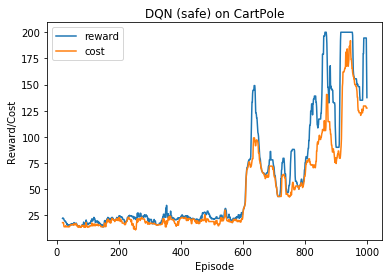

In [102]:
plt.figure()
plt.title('DQN (safe) on CartPole')
plt.plot(pd.DataFrame(r).rolling(20).median(), label = 'reward')
plt.plot(pd.DataFrame(c).rolling(20).median(), label = 'cost')
plt.xlabel('Episode')
plt.ylabel('Reward/Cost')
plt.savefig('sdqn.eps', bbox_inches = 'tight')
plt.legend()
plt.show()

Weird that the agent unlearns everything for some reason. What works and doesn't work:
1. Bellman (b) + JSD (j) + log_r for action selection - 
2. b log_r -
3. r log_r +- (goes up/down)
4. b + j log_pi no
5. r log_r log_r in R loss NO ??? also, reward doesn't go down with exploration?.. fixed when sampling argmax instead of sampling. For q-logits the policy should be argmax!, works
6. B log_r log_r argmax + (now -???..)
6. B+J log_r log_r argmax - ??? Why just adding a loss makes it worse? Are they scaled inappropriately? Or are they using the same layer making it follow two tasks? Want to be confident when solving this... It immediately made me solve this problems and spot the odd thing. It's so much more productive than monkey-coding. Why did I switch to it? It makes sense it doesn't work since I use soft Bellman loss
8. B log_r x 2 no common layer kinda, -

Hypothesis: experience replay is not implemented correctly. Check all equations. heck what target pi' is.

**19th May** I think it shouldn't work because soft bellman loss wouldn't work for q-logits which are approximately the same

Trying to make policy network to work...
1. Mistake in call to pulp: first argument was treated as name and not as Maximize
2. And it fucking works! ANd it stopped working again... Not sure what's the difference... Made separate optimizers -- didn't help. Added summaries (noticed that losses are of different magnitude)
3. Error in making JSD != Inf because used list == 0 instead of np.array == 0
4. Error in soft_bellman_loss: calculating gradient w.r.t. logits_policy too (don't need that)
5. Need to replace policy_new by policy in loss_r? Why is it different? It makes sense to train Q with argmaxQ policy and not on-policy...
6. Mistake: 10 batch size instead of 1000
7. q-function for R seems to blow up. Reducing expreplay to 1000 and updates to 100 like in DQN. Trying to decrease network size... +!!! And NO again... Nothing changed...
8. Hypothesis: q-function doesn't blow up, the norm is not computed properly. True. q-function is now correct... What if I act on it? Indeed, it works if I act on the Q-function. Maybe it means that I do too few updates for pi_new? Or that I run it for too few iterations? Or that Q-function converges only at 1000th iteration? Trying to make it converge faster by decreasing eps faster
9. If Q-function is optimized for 10 times, performance decreases. Splitting optimizers for Bellman and JSD and optimizing only JSD 10 times. Q-function converges after 500 train steps. Increasing the buffer size made it more stable! Trying to see the difference between policy and q_R. It's huge... Trying to track it... This thing doesn't go down much... Replacing it with MSE and running for 50 times doesn't help. Trying 150... Hypothesis: this happens because I use 0.01 in the loss.
10. For some reason, pi --/-> q_R even if it's explicitly trained to match it. It just makes first component really small and the second close to 1... It starts fine but then makes first comonent 0 and that's it. It overfits to the data? So I make too _many_ iterations? No, 5 still makes it like this. Hypothesis: Q-learning should be done first with policy optimization only after, otherwise it goes way down? True. Only training after a certain step makes it better... Fixed the 0.01 in the LP. Very negative values have disappeared.. Fuck...
10. Switched to JSD. Adding more iterations for it... more iterations lead to overfit. Switched back to MSE. Training after q w/o changing q makes pi converge to q, even with softmax activation/wo it!

In [39]:
L = 100
d0_ = 1000

S0, A, R, S1, N, C = list(zip(*replay.sample(L)))
    
# converting to float
N = 1. * np.array(N)

# feed dictionary for TF
feed = {states: interleave(S0, S1), actions: A, rewards: R, costs: C,
        d0: d0_, need_next_q: N, termination: 1 - N}
    
# obtaining current policy
pi_k, q_L, q_R, eps_L = sess.run((logits_from, q_lyapunov, q_reward, eps_lyapunov), feed_dict = feed)

In [40]:
np.argmax(q_R, axis = 1)

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0])

In [41]:
np.argmax(pi_k, axis = 1)

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [42]:
len(get_rollout())

200

In [43]:
#env = env.unwrapped
#env = gym.wrappers.Monitor(env, './video')
#get_rollout()
#sess.run(params)
#tf.train.Saver().save(sess, './cartpole-h1.ckpt')
#tf.train.Saver().restore(sess, './cartpole-h1.ckpt')